# VQ-VAE training example

Demonstration of how to train the model specified in https://arxiv.org/abs/1711.00937, using Haiku / JAX.

On Mac and Linux, simply execute each cell in turn.

In [1]:
# Uncomment the line below if running on colab.research.google.com
# !pip install dm-haiku optax

In [2]:
import haiku as hk
import jax
import optax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

tf.enable_v2_behavior()

print("JAX version {}".format(jax.__version__))
print("Haiku version {}".format(hk.__version__))
print("TF version {}".format(tf.__version__))

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

JAX version 0.2.24
Haiku version 0.0.4
TF version 2.5.0


# Download Cifar10 data
This requires a connection to the internet and will download ~160MB.


In [8]:
cifar10 = tfds.as_numpy(tfds.load("cifar10", split="train+test", batch_size=-1, download=False))
del cifar10["id"], cifar10["label"]
jax.tree_map(lambda x: f'{x.dtype.name}{list(x.shape)}', cifar10)

2022-03-08 14:31:07.374753: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 184320000 exceeds 10% of free system memory.


{'image': 'uint8[60000, 32, 32, 3]'}

# Load the data into Numpy
We compute the variance of the whole training set to normalise the Mean Squared Error below.


In [9]:
train_data_dict = jax.tree_map(lambda x: x[:40000], cifar10)
valid_data_dict = jax.tree_map(lambda x: x[40000:50000], cifar10)
test_data_dict = jax.tree_map(lambda x: x[50000:], cifar10)

In [10]:
def cast_and_normalise_images(data_dict):
  """Convert images to floating point with the range [-0.5, 0.5]"""
  data_dict['image'] = (tf.cast(data_dict['image'], tf.float32) / 255.0) - 0.5
  return data_dict

train_data_variance = np.var(train_data_dict['image'] / 255.0)
print('train data variance: %s' % train_data_variance)

train data variance: 0.06327039811675479


# Encoder & Decoder Architecture


In [11]:
class ResidualStack(hk.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(ResidualStack, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._layers = []
    for i in range(num_residual_layers):
      conv3 = hk.Conv2D(
          output_channels=num_residual_hiddens,
          kernel_shape=(3, 3),
          stride=(1, 1),
          name="res3x3_%d" % i)
      conv1 = hk.Conv2D(
          output_channels=num_hiddens,
          kernel_shape=(1, 1),
          stride=(1, 1),
          name="res1x1_%d" % i)
      self._layers.append((conv3, conv1))

  def __call__(self, inputs):
    h = inputs
    for conv3, conv1 in self._layers:
      conv3_out = conv3(jax.nn.relu(h))
      conv1_out = conv1(jax.nn.relu(conv3_out))
      h += conv1_out
    return jax.nn.relu(h)  # Resnet V1 style


class Encoder(hk.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(Encoder, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._enc_1 = hk.Conv2D(
        output_channels=self._num_hiddens // 2,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="enc_1")
    self._enc_2 = hk.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="enc_2")
    self._enc_3 = hk.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(3, 3),
        stride=(1, 1),
        name="enc_3")
    self._residual_stack = ResidualStack(
        self._num_hiddens,
        self._num_residual_layers,
        self._num_residual_hiddens)

  def __call__(self, x):
    h = jax.nn.relu(self._enc_1(x))
    h = jax.nn.relu(self._enc_2(h))
    h = jax.nn.relu(self._enc_3(h))
    return self._residual_stack(h)


class Decoder(hk.Module):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name=None):
    super(Decoder, self).__init__(name=name)
    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens

    self._dec_1 = hk.Conv2D(
        output_channels=self._num_hiddens,
        kernel_shape=(3, 3),
        stride=(1, 1),
        name="dec_1")
    self._residual_stack = ResidualStack(
        self._num_hiddens,
        self._num_residual_layers,
        self._num_residual_hiddens)
    self._dec_2 = hk.Conv2DTranspose(
        output_channels=self._num_hiddens // 2,
        # output_shape=None,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="dec_2")
    self._dec_3 = hk.Conv2DTranspose(
        output_channels=3,
        # output_shape=None,
        kernel_shape=(4, 4),
        stride=(2, 2),
        name="dec_3")
    
  def __call__(self, x):
    h = self._dec_1(x)
    h = self._residual_stack(h)
    h = jax.nn.relu(self._dec_2(h))
    x_recon = self._dec_3(h)
    return x_recon
    

class VQVAEModel(hk.Module):
  def __init__(self, encoder, decoder, vqvae, pre_vq_conv1, 
               data_variance, name=None):
    super(VQVAEModel, self).__init__(name=name)
    self._encoder = encoder
    self._decoder = decoder
    self._vqvae = vqvae
    self._pre_vq_conv1 = pre_vq_conv1
    self._data_variance = data_variance

  def __call__(self, inputs, is_training):
    z = self._pre_vq_conv1(self._encoder(inputs))
    vq_output = self._vqvae(z, is_training=is_training)
    x_recon = self._decoder(vq_output['quantize'])
    recon_error = jnp.mean((x_recon - inputs) ** 2) / self._data_variance
    loss = recon_error + vq_output['loss']
    return {
        'z': z,
        'x_recon': x_recon,
        'loss': loss,
        'recon_error': recon_error,
        'vq_output': vq_output,
    }

# Build Model and train

In [12]:
# Set hyper-parameters.
batch_size = 32
image_size = 32

# 100k steps should take < 30 minutes on a modern (>= 2017) GPU.
num_training_updates = 100000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2
# These hyper-parameters define the size of the model (number of parameters and layers).
# The hyper-parameters in the paper were (For ImageNet):
# batch_size = 128
# image_size = 128
# num_hiddens = 128
# num_residual_hiddens = 32
# num_residual_layers = 2

# This value is not that important, usually 64 works.
# This will not change the capacity in the information-bottleneck.
embedding_dim = 64

# The higher this value, the higher the capacity in the information bottleneck.
num_embeddings = 512

# commitment_cost should be set appropriately. It's often useful to try a couple
# of values. It mostly depends on the scale of the reconstruction cost
# (log p(x|z)). So if the reconstruction cost is 100x higher, the
# commitment_cost should also be multiplied with the same amount.
commitment_cost = 0.25

# Use EMA updates for the codebook (instead of the Adam optimizer).
# This typically converges faster, and makes the model less dependent on choice
# of the optimizer. In the VQ-VAE paper EMA updates were not used (but was
# developed afterwards). See Appendix of the paper for more details.
vq_use_ema = True

# This is only used for EMA updates.
decay = 0.99

learning_rate = 3e-4


# # Data Loading.
train_dataset = tfds.as_numpy(
    tf.data.Dataset.from_tensor_slices(train_data_dict)
    .map(cast_and_normalise_images)
    .shuffle(10000)
    .repeat(-1)  # repeat indefinitely
    .batch(batch_size, drop_remainder=True)
    .prefetch(-1))
valid_dataset = tfds.as_numpy(
    tf.data.Dataset.from_tensor_slices(valid_data_dict)
    .map(cast_and_normalise_images)
    .repeat(1)  # 1 epoch
    .batch(batch_size)
    .prefetch(-1))

# # Build modules.
def forward(data, is_training):
  encoder = Encoder(num_hiddens, num_residual_layers, num_residual_hiddens)
  decoder = Decoder(num_hiddens, num_residual_layers, num_residual_hiddens)
  pre_vq_conv1 = hk.Conv2D(
      output_channels=embedding_dim,
      kernel_shape=(1, 1),
      stride=(1, 1),
      name="to_vq")

  if vq_use_ema:
    vq_vae = hk.nets.VectorQuantizerEMA(
        embedding_dim=embedding_dim,
        num_embeddings=num_embeddings,
        commitment_cost=commitment_cost,
        decay=decay)
  else:
    vq_vae = hk.nets.VectorQuantizer(
        embedding_dim=embedding_dim,
        num_embeddings=num_embeddings,
        commitment_cost=commitment_cost)
    
  model = VQVAEModel(encoder, decoder, vq_vae, pre_vq_conv1,
                     data_variance=train_data_variance)

  return model(data['image'], is_training)

forward = hk.transform_with_state(forward)
optimizer = optax.adam(learning_rate)

@jax.jit
def train_step(params, state, opt_state, data):
  def adapt_forward(params, state, data):
    # Pack model output and state together.
    model_output, state = forward.apply(params, state, None, data, is_training=True)
    loss = model_output['loss']
    return loss, (model_output, state)

  grads, (model_output, state) = (
      jax.grad(adapt_forward, has_aux=True)(params, state, data))

  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  return params, state, opt_state, model_output

In [13]:
%%time

train_losses = []
train_recon_errors = []
train_perplexities = []
train_vqvae_loss = []

rng = jax.random.PRNGKey(42)
train_dataset_iter = iter(train_dataset)
params, state = forward.init(rng, next(train_dataset_iter), is_training=True)
opt_state = optimizer.init(params)

for step in range(1, num_training_updates + 1):
  data = next(train_dataset_iter)
  params, state, opt_state, train_results = (
      train_step(params, state, opt_state, data))

  train_results = jax.device_get(train_results)
  train_losses.append(train_results['loss'])
  train_recon_errors.append(train_results['recon_error'])
  train_perplexities.append(train_results['vq_output']['perplexity'])
  train_vqvae_loss.append(train_results['vq_output']['loss'])

  if step % 100 == 0:
    print(f'[Step {step}/{num_training_updates}] ' + 
          ('train loss: %f ' % np.mean(train_losses[-100:])) +
          ('recon_error: %.3f ' % np.mean(train_recon_errors[-100:])) +
          ('perplexity: %.3f ' % np.mean(train_perplexities[-100:])) +
          ('vqvae loss: %.3f' % np.mean(train_vqvae_loss[-100:])))

2022-03-08 14:31:22.752491: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 122880000 exceeds 10% of free system memory.


[Step 100/100000] train loss: 0.500848 recon_error: 0.464 perplexity: 8.113 vqvae loss: 0.036
[Step 200/100000] train loss: 0.273238 recon_error: 0.241 perplexity: 12.759 vqvae loss: 0.033
[Step 300/100000] train loss: 0.224645 recon_error: 0.193 perplexity: 18.563 vqvae loss: 0.032
[Step 400/100000] train loss: 0.197640 recon_error: 0.167 perplexity: 24.535 vqvae loss: 0.031
[Step 500/100000] train loss: 0.183497 recon_error: 0.149 perplexity: 29.937 vqvae loss: 0.034
[Step 600/100000] train loss: 0.176869 recon_error: 0.140 perplexity: 34.169 vqvae loss: 0.036
[Step 700/100000] train loss: 0.162292 recon_error: 0.127 perplexity: 39.711 vqvae loss: 0.035
[Step 800/100000] train loss: 0.154744 recon_error: 0.121 perplexity: 44.731 vqvae loss: 0.034
[Step 900/100000] train loss: 0.146635 recon_error: 0.114 perplexity: 49.760 vqvae loss: 0.033
[Step 1000/100000] train loss: 0.137647 recon_error: 0.107 perplexity: 54.760 vqvae loss: 0.031
[Step 1100/100000] train loss: 0.135849 recon_erro

[Step 8600/100000] train loss: 0.093585 recon_error: 0.057 perplexity: 330.530 vqvae loss: 0.037
[Step 8700/100000] train loss: 0.093529 recon_error: 0.057 perplexity: 329.675 vqvae loss: 0.037
[Step 8800/100000] train loss: 0.091272 recon_error: 0.055 perplexity: 327.825 vqvae loss: 0.036
[Step 8900/100000] train loss: 0.093048 recon_error: 0.056 perplexity: 329.632 vqvae loss: 0.037
[Step 9000/100000] train loss: 0.092931 recon_error: 0.057 perplexity: 327.711 vqvae loss: 0.036
[Step 9100/100000] train loss: 0.093289 recon_error: 0.057 perplexity: 330.793 vqvae loss: 0.037
[Step 9200/100000] train loss: 0.093501 recon_error: 0.057 perplexity: 326.447 vqvae loss: 0.036
[Step 9300/100000] train loss: 0.093264 recon_error: 0.056 perplexity: 330.278 vqvae loss: 0.037
[Step 9400/100000] train loss: 0.093140 recon_error: 0.056 perplexity: 332.088 vqvae loss: 0.037
[Step 9500/100000] train loss: 0.092760 recon_error: 0.056 perplexity: 326.204 vqvae loss: 0.036
[Step 9600/100000] train loss:

[Step 17000/100000] train loss: 0.089725 recon_error: 0.054 perplexity: 330.786 vqvae loss: 0.036
[Step 17100/100000] train loss: 0.088836 recon_error: 0.053 perplexity: 331.116 vqvae loss: 0.036
[Step 17200/100000] train loss: 0.088915 recon_error: 0.054 perplexity: 331.997 vqvae loss: 0.035
[Step 17300/100000] train loss: 0.089650 recon_error: 0.054 perplexity: 331.812 vqvae loss: 0.036
[Step 17400/100000] train loss: 0.088352 recon_error: 0.053 perplexity: 329.460 vqvae loss: 0.035
[Step 17500/100000] train loss: 0.089627 recon_error: 0.054 perplexity: 334.120 vqvae loss: 0.036
[Step 17600/100000] train loss: 0.089356 recon_error: 0.054 perplexity: 329.608 vqvae loss: 0.036
[Step 17700/100000] train loss: 0.089553 recon_error: 0.054 perplexity: 334.084 vqvae loss: 0.036
[Step 17800/100000] train loss: 0.088061 recon_error: 0.053 perplexity: 330.262 vqvae loss: 0.035
[Step 17900/100000] train loss: 0.089074 recon_error: 0.054 perplexity: 333.175 vqvae loss: 0.035
[Step 18000/100000] 

[Step 25400/100000] train loss: 0.087551 recon_error: 0.053 perplexity: 336.050 vqvae loss: 0.035
[Step 25500/100000] train loss: 0.084734 recon_error: 0.051 perplexity: 327.719 vqvae loss: 0.034
[Step 25600/100000] train loss: 0.086272 recon_error: 0.052 perplexity: 336.764 vqvae loss: 0.034
[Step 25700/100000] train loss: 0.086894 recon_error: 0.053 perplexity: 334.384 vqvae loss: 0.034
[Step 25800/100000] train loss: 0.086622 recon_error: 0.052 perplexity: 334.369 vqvae loss: 0.034
[Step 25900/100000] train loss: 0.087553 recon_error: 0.053 perplexity: 335.143 vqvae loss: 0.035
[Step 26000/100000] train loss: 0.086802 recon_error: 0.052 perplexity: 332.122 vqvae loss: 0.034
[Step 26100/100000] train loss: 0.087650 recon_error: 0.053 perplexity: 334.822 vqvae loss: 0.035
[Step 26200/100000] train loss: 0.086285 recon_error: 0.052 perplexity: 329.299 vqvae loss: 0.034
[Step 26300/100000] train loss: 0.085627 recon_error: 0.052 perplexity: 331.773 vqvae loss: 0.034
[Step 26400/100000] 

[Step 33800/100000] train loss: 0.085142 recon_error: 0.052 perplexity: 332.728 vqvae loss: 0.034
[Step 33900/100000] train loss: 0.085842 recon_error: 0.052 perplexity: 335.319 vqvae loss: 0.034
[Step 34000/100000] train loss: 0.085864 recon_error: 0.052 perplexity: 335.118 vqvae loss: 0.034
[Step 34100/100000] train loss: 0.085885 recon_error: 0.052 perplexity: 334.860 vqvae loss: 0.034
[Step 34200/100000] train loss: 0.085973 recon_error: 0.052 perplexity: 335.915 vqvae loss: 0.034
[Step 34300/100000] train loss: 0.085480 recon_error: 0.052 perplexity: 333.613 vqvae loss: 0.034
[Step 34400/100000] train loss: 0.084024 recon_error: 0.051 perplexity: 331.127 vqvae loss: 0.033
[Step 34500/100000] train loss: 0.083895 recon_error: 0.051 perplexity: 331.657 vqvae loss: 0.033
[Step 34600/100000] train loss: 0.086398 recon_error: 0.052 perplexity: 337.502 vqvae loss: 0.034
[Step 34700/100000] train loss: 0.085456 recon_error: 0.052 perplexity: 335.211 vqvae loss: 0.034
[Step 34800/100000] 

[Step 42200/100000] train loss: 0.084417 recon_error: 0.051 perplexity: 336.547 vqvae loss: 0.033
[Step 42300/100000] train loss: 0.084836 recon_error: 0.051 perplexity: 336.005 vqvae loss: 0.034
[Step 42400/100000] train loss: 0.084961 recon_error: 0.051 perplexity: 335.519 vqvae loss: 0.034
[Step 42500/100000] train loss: 0.084986 recon_error: 0.051 perplexity: 335.104 vqvae loss: 0.034
[Step 42600/100000] train loss: 0.084723 recon_error: 0.051 perplexity: 333.947 vqvae loss: 0.034
[Step 42700/100000] train loss: 0.084591 recon_error: 0.051 perplexity: 334.502 vqvae loss: 0.034
[Step 42800/100000] train loss: 0.085298 recon_error: 0.052 perplexity: 335.094 vqvae loss: 0.034
[Step 42900/100000] train loss: 0.084879 recon_error: 0.051 perplexity: 336.436 vqvae loss: 0.033
[Step 43000/100000] train loss: 0.085055 recon_error: 0.051 perplexity: 334.823 vqvae loss: 0.034
[Step 43100/100000] train loss: 0.084017 recon_error: 0.051 perplexity: 336.446 vqvae loss: 0.033
[Step 43200/100000] 

[Step 50600/100000] train loss: 0.084321 recon_error: 0.051 perplexity: 337.242 vqvae loss: 0.034
[Step 50700/100000] train loss: 0.083948 recon_error: 0.051 perplexity: 335.656 vqvae loss: 0.033
[Step 50800/100000] train loss: 0.083631 recon_error: 0.050 perplexity: 336.839 vqvae loss: 0.033
[Step 50900/100000] train loss: 0.084902 recon_error: 0.051 perplexity: 336.758 vqvae loss: 0.034
[Step 51000/100000] train loss: 0.085028 recon_error: 0.051 perplexity: 339.957 vqvae loss: 0.034
[Step 51100/100000] train loss: 0.084396 recon_error: 0.051 perplexity: 335.005 vqvae loss: 0.033
[Step 51200/100000] train loss: 0.084501 recon_error: 0.051 perplexity: 334.476 vqvae loss: 0.034
[Step 51300/100000] train loss: 0.084161 recon_error: 0.051 perplexity: 336.596 vqvae loss: 0.033
[Step 51400/100000] train loss: 0.083556 recon_error: 0.051 perplexity: 332.904 vqvae loss: 0.033
[Step 51500/100000] train loss: 0.085251 recon_error: 0.051 perplexity: 336.074 vqvae loss: 0.034
[Step 51600/100000] 

[Step 59000/100000] train loss: 0.084409 recon_error: 0.051 perplexity: 338.426 vqvae loss: 0.033
[Step 59100/100000] train loss: 0.084003 recon_error: 0.051 perplexity: 337.261 vqvae loss: 0.033
[Step 59200/100000] train loss: 0.084415 recon_error: 0.051 perplexity: 337.884 vqvae loss: 0.034
[Step 59300/100000] train loss: 0.083553 recon_error: 0.050 perplexity: 337.221 vqvae loss: 0.033
[Step 59400/100000] train loss: 0.084307 recon_error: 0.051 perplexity: 338.798 vqvae loss: 0.034
[Step 59500/100000] train loss: 0.083790 recon_error: 0.050 perplexity: 334.665 vqvae loss: 0.033
[Step 59600/100000] train loss: 0.083123 recon_error: 0.050 perplexity: 338.966 vqvae loss: 0.033
[Step 59700/100000] train loss: 0.084803 recon_error: 0.051 perplexity: 336.322 vqvae loss: 0.034
[Step 59800/100000] train loss: 0.083837 recon_error: 0.051 perplexity: 335.906 vqvae loss: 0.033
[Step 59900/100000] train loss: 0.084336 recon_error: 0.051 perplexity: 336.344 vqvae loss: 0.034
[Step 60000/100000] 

[Step 67400/100000] train loss: 0.083423 recon_error: 0.050 perplexity: 338.141 vqvae loss: 0.033
[Step 67500/100000] train loss: 0.083765 recon_error: 0.050 perplexity: 338.108 vqvae loss: 0.033
[Step 67600/100000] train loss: 0.083157 recon_error: 0.050 perplexity: 338.491 vqvae loss: 0.033
[Step 67700/100000] train loss: 0.083837 recon_error: 0.050 perplexity: 338.909 vqvae loss: 0.034
[Step 67800/100000] train loss: 0.083350 recon_error: 0.050 perplexity: 336.558 vqvae loss: 0.033
[Step 67900/100000] train loss: 0.082845 recon_error: 0.050 perplexity: 337.673 vqvae loss: 0.033
[Step 68000/100000] train loss: 0.084896 recon_error: 0.051 perplexity: 338.979 vqvae loss: 0.034
[Step 68100/100000] train loss: 0.083658 recon_error: 0.051 perplexity: 335.766 vqvae loss: 0.033
[Step 68200/100000] train loss: 0.084104 recon_error: 0.051 perplexity: 337.671 vqvae loss: 0.034
[Step 68300/100000] train loss: 0.084387 recon_error: 0.051 perplexity: 340.540 vqvae loss: 0.034
[Step 68400/100000] 

[Step 75800/100000] train loss: 0.084319 recon_error: 0.050 perplexity: 337.745 vqvae loss: 0.034
[Step 75900/100000] train loss: 0.084781 recon_error: 0.051 perplexity: 342.066 vqvae loss: 0.034
[Step 76000/100000] train loss: 0.082705 recon_error: 0.049 perplexity: 338.418 vqvae loss: 0.033
[Step 76100/100000] train loss: 0.083516 recon_error: 0.050 perplexity: 338.553 vqvae loss: 0.033
[Step 76200/100000] train loss: 0.082546 recon_error: 0.049 perplexity: 336.225 vqvae loss: 0.033
[Step 76300/100000] train loss: 0.082462 recon_error: 0.049 perplexity: 337.356 vqvae loss: 0.033
[Step 76400/100000] train loss: 0.082572 recon_error: 0.050 perplexity: 338.195 vqvae loss: 0.033
[Step 76500/100000] train loss: 0.084195 recon_error: 0.051 perplexity: 337.691 vqvae loss: 0.033
[Step 76600/100000] train loss: 0.083144 recon_error: 0.050 perplexity: 339.897 vqvae loss: 0.033
[Step 76700/100000] train loss: 0.083589 recon_error: 0.050 perplexity: 339.007 vqvae loss: 0.033
[Step 76800/100000] 

[Step 84200/100000] train loss: 0.083011 recon_error: 0.050 perplexity: 341.310 vqvae loss: 0.033
[Step 84300/100000] train loss: 0.083481 recon_error: 0.050 perplexity: 339.995 vqvae loss: 0.034
[Step 84400/100000] train loss: 0.084003 recon_error: 0.050 perplexity: 342.408 vqvae loss: 0.034
[Step 84500/100000] train loss: 0.082600 recon_error: 0.049 perplexity: 337.246 vqvae loss: 0.033
[Step 84600/100000] train loss: 0.082873 recon_error: 0.050 perplexity: 339.325 vqvae loss: 0.033
[Step 84700/100000] train loss: 0.083236 recon_error: 0.050 perplexity: 340.821 vqvae loss: 0.033
[Step 84800/100000] train loss: 0.083454 recon_error: 0.050 perplexity: 341.643 vqvae loss: 0.034
[Step 84900/100000] train loss: 0.084776 recon_error: 0.050 perplexity: 338.966 vqvae loss: 0.035
[Step 85000/100000] train loss: 0.084036 recon_error: 0.051 perplexity: 339.412 vqvae loss: 0.033
[Step 85100/100000] train loss: 0.083470 recon_error: 0.050 perplexity: 339.570 vqvae loss: 0.033
[Step 85200/100000] 

[Step 92600/100000] train loss: 0.082677 recon_error: 0.050 perplexity: 336.330 vqvae loss: 0.033
[Step 92700/100000] train loss: 0.083092 recon_error: 0.050 perplexity: 341.090 vqvae loss: 0.034
[Step 92800/100000] train loss: 0.084076 recon_error: 0.050 perplexity: 342.009 vqvae loss: 0.034
[Step 92900/100000] train loss: 0.082959 recon_error: 0.050 perplexity: 337.722 vqvae loss: 0.033
[Step 93000/100000] train loss: 0.083562 recon_error: 0.050 perplexity: 341.206 vqvae loss: 0.034
[Step 93100/100000] train loss: 0.082537 recon_error: 0.049 perplexity: 336.824 vqvae loss: 0.033
[Step 93200/100000] train loss: 0.082658 recon_error: 0.049 perplexity: 341.547 vqvae loss: 0.033
[Step 93300/100000] train loss: 0.083678 recon_error: 0.050 perplexity: 341.957 vqvae loss: 0.034
[Step 93400/100000] train loss: 0.083408 recon_error: 0.050 perplexity: 339.885 vqvae loss: 0.034
[Step 93500/100000] train loss: 0.083377 recon_error: 0.050 perplexity: 340.574 vqvae loss: 0.034
[Step 93600/100000] 

# Plot loss

Text(0.5, 1.0, 'Average codebook usage (perplexity).')

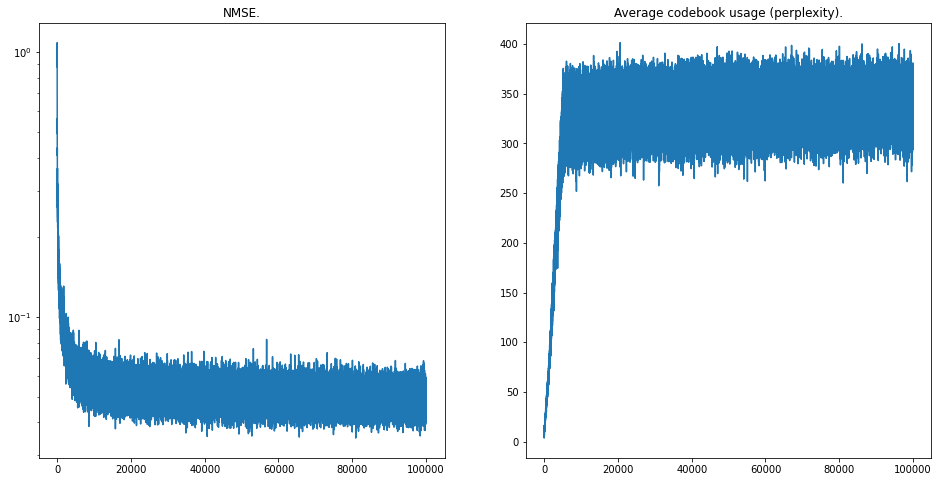

In [14]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_recon_errors)
ax.set_yscale('log')
ax.set_title('NMSE.')

ax = f.add_subplot(1,2,2)
ax.plot(train_perplexities)
ax.set_title('Average codebook usage (perplexity).')

# View reconstructions

2022-03-08 14:44:23.734385: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 122880000 exceeds 10% of free system memory.


(-0.5, 255.5, 127.5, -0.5)

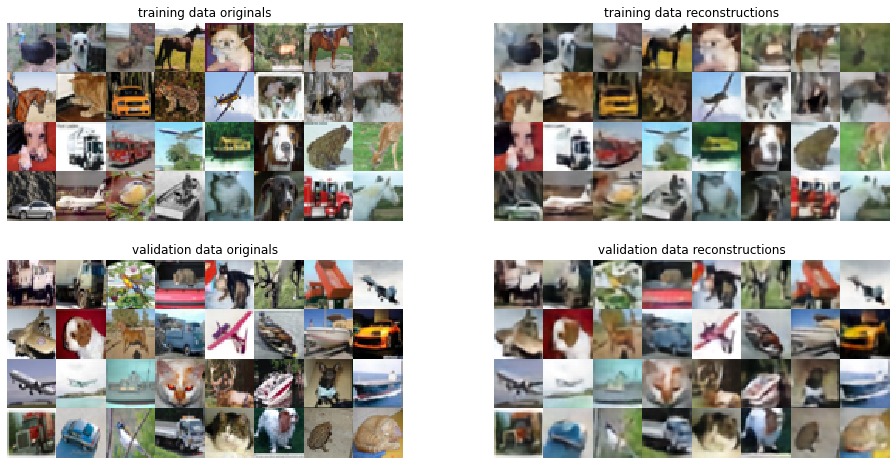

In [15]:
# Reconstructions
train_batch = next(iter(train_dataset))
valid_batch = next(iter(valid_dataset))

# Put data through the model with is_training=False, so that in the case of 
# using EMA the codebook is not updated.
train_reconstructions = forward.apply(params, state, rng, train_batch, is_training=False)[0]['x_recon']
valid_reconstructions = forward.apply(params, state, rng, valid_batch, is_training=False)[0]['x_recon']


def convert_batch_to_image_grid(image_batch):
  reshaped = (image_batch.reshape(4, 8, 32, 32, 3)
              .transpose([0, 2, 1, 3, 4])
              .reshape(4 * 32, 8 * 32, 3))
  return reshaped + 0.5



f = plt.figure(figsize=(16,8))
ax = f.add_subplot(2,2,1)
ax.imshow(convert_batch_to_image_grid(train_batch['image']),
          interpolation='nearest')
ax.set_title('training data originals')
plt.axis('off')

ax = f.add_subplot(2,2,2)
ax.imshow(convert_batch_to_image_grid(train_reconstructions),
          interpolation='nearest')
ax.set_title('training data reconstructions')
plt.axis('off')

ax = f.add_subplot(2,2,3)
ax.imshow(convert_batch_to_image_grid(valid_batch['image']),
          interpolation='nearest')
ax.set_title('validation data originals')
plt.axis('off')

ax = f.add_subplot(2,2,4)
ax.imshow(convert_batch_to_image_grid(valid_reconstructions),
          interpolation='nearest')
ax.set_title('validation data reconstructions')
plt.axis('off')